# Objective:

Classify Amazon food reviews using Support Vector Classifier.

We'll do the following exercises in this notebook

* Load and standardize the data in the format
        1. BoW
        2. Tfidf
        3. Avg. W2V
        4. Tfidf weighted W2V
* Divide the data in cross validation sets and find the optimal parameters C and gamma using GridSearchCV and RandomizedSearchCV
* Plot the Cross Validation score for each combination of gamma and C in Cross Validation
* Plot confusion matrix and calculate Precision, Recall, FPR, TNR, FNR. 



In [0]:
# To suprress the warnings as they make the notebook less presentable.

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

Import the necessary libraries.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import pickle
import numpy as np
from sklearn.svm import SVC

This Jupyter notebook extension notifies you when a cell finishes its execution!

In [0]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

## Important parameters of Support Vector Machines

* C : This trades off correct classification of training examples against maximization of the decision function’s margin
* gamma : Defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’

Load the target variable y of train and test sets. Note that the entire dataset is being used. All 350k reviews. The dataset is divided into train and test with ratio 80:20 respectively.

In [0]:
#f = open(r'D:\data_science\datasets\amazon2\y_train_full80_20.pkl', 'rb')
f = open('/home/ucanreachtvk/data/y_train_full80_20.pkl', 'rb')
y_train = pickle.load(f)
f.close()
print('The datatype of y_train is : {}'.format(type(y_train)))
print('The shape of y_train is : {}'.format(y_train.shape))

The datatype of y_train is : <class 'numpy.ndarray'>
The shape of y_train is : (291336,)


In [0]:
#f = open(r'D:\data_science\datasets\amazon2\y_test_full80_20.pkl', 'rb')
f = open('/home/ucanreachtvk/data/y_test_full80_20.pkl', 'rb')
y_test = pickle.load(f)
f.close()
print('The datatype of y_test is : {}'.format(type(y_test)))
print('The shape of y_test is : {}'.format(y_test.shape))

The datatype of y_test is : <class 'numpy.ndarray'>
The shape of y_test is : (72835,)


Since Grid Search on a number of hyperparameters for SVM is expensive, I'll use 50k reviews. These are contiguous in time. So the temporal structure of the data is preserved.

In [0]:
y_test = y_test[:10000]
y_train = y_train[-40000:]

## Bag of Words

I had saved the trained BoW model and the transformed data on disk. Let's load it. 

In [0]:
#f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_bow_full_nparray.pkl', 'rb')
X_train_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_bow is : {}'.format(type(X_train_transformed_bow)))
print('The shape of X_train_transformed_bow is : {}'.format(X_train_transformed_bow.shape))

The datatype of X_train_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_bow is : (291336, 64221)


There are 64221 features in the bow representation. Load test data too.

In [0]:
#f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_bow_full_nparray.pkl', 'rb')
X_test_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_bow is : {}'.format(type(X_test_transformed_bow)))
print('The shape of X_test_transformed_bow is : {}'.format(X_test_transformed_bow.shape))

The datatype of X_test_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_bow is : (72835, 64221)


In [0]:
X_test_transformed_bow = X_test_transformed_bow[:10000]
X_train_transformed_bow = X_train_transformed_bow[-40000:]

Count the number of non-zero elements in the array.

In [0]:
X_train_transformed_bow.count_nonzero

<bound method _data_matrix.count_nonzero of <40000x64221 sparse matrix of type '<class 'numpy.int64'>'
	with 1316382 stored elements in Compressed Sparse Row format>>

## Feature scaling

Standardize the data.

In [0]:
scaler = StandardScaler(with_mean = False)
X_train_transformed_bow_std = scaler.fit_transform(X_train_transformed_bow)

In [0]:
X_test_transformed_bow_std = scaler.transform(X_test_transformed_bow)

In [0]:
X_train_transformed_bow_std.shape

(40000, 64221)

In [0]:
y_train.shape

(40000,)

## Some Functions

Let's define some functions that we'll call repeatedly in this notebook. 

1. **c_gamma_score** : Returns a dataframe containing the C, gamma, score found during cross validation

2. **give_me_ratios** : To plot ratios such as Precision, Recall, TNR, FPR, FNR.
3. **plot_confusion_matrix** : As the name says.
4. **GridSearch** : Create Time based cross validation splits using TimeSeriesSplit() and  create a gridsearch object for a support vector classifier.
5. **RandomSearch**: Same as GridSearch except that it uses RandomizedSearchCV()
6. **headmap** : For each pair of (C, gamma) value in GridSearch, it will plot the score for train and test data during cross validation. For RandomizedSearchCV, for the pair of values not tried by the classifier, it will show -1 (NA).

In [0]:
def c_gamma_score(cv_results_):

    D={'c':[], 'gamma':[], 'score':[]}

    for c in [0.01, 0.1, 10, 100]:

        for gamma in ['auto',0.01, 0.1, 1, 10]:

            d={'C': c, 'gamma': gamma}
            
            flag=True
            
            try:
            
                ind=cv_results_['params'].index(d)
            
            except:
                
                flag = False

            D['c'].append(c)
            D['gamma'].append(gamma)
            
            if flag == False:
                
                D['score'].append(-1)
            
            else:
                D['score'].append(cv_results_['mean_train_score'][ind])
                
    return(pd.DataFrame.from_dict(D)) 

In [0]:
def give_me_ratios(X_train, y_train, X_test, y_test, vector_type,search, table, clf, best_c, best_gamma): 
    
    cm_train = confusion_matrix(y_train, clf.predict(X_train))
    tn, fp, fn, tp = cm_train.ravel()

    recall_train = round(tp/(tp+fn),2)
    precision_train = round(tp/(tp+fp),2)
    tnr_train = round(tn/(tn+fp),2)
    fpr_train = round(fp/(fp+tn),2)
    fnr_train = round(fn/(fn+tp),2)
    accuracy_train = round((tp+tn)/(tp+tn+fp+fn))
    accuracy_train = (tp+tn)/(tp+tn+fp+fn)

    cm_test = confusion_matrix(y_test, clf.predict(X_test))
    tn, fp, fn, tp = cm_test.ravel()
    recall_test = round(tp/(tp+fn),2)
    precision_test = round(tp/(tp+fp),2)
    tnr_test = round(tn/(tn+fp),2)
    fpr_test = round(fp/(fp+tn),2)
    fnr_test = round(fn/(fn+tp),2)
    accuracy_test = round(tp+tn)/(tp+tn+fp+fn)

    table.field_names = ['Vector Type','Parameter Search','Data Set','Best C','Best Gamma', 'Precision', 'Recall', 'TNR', 'FPR', 'FNR', 'Accuracy']
    table.add_row([vector_type,search,'Train',best_c,best_gamma, precision_train, recall_train, tnr_train, fpr_train, fnr_train, accuracy_train])
    table.add_row([vector_type,search,'Test',best_c,best_gamma, precision_test, recall_test, tnr_test, fpr_test, fnr_test, accuracy_test])

    print(table)
    
    return (cm_train, cm_test)

In [0]:
def plot_confusion_matrix(cm_train, cm_test, title):
    
    import pandas as pd
    plt.figure(figsize=(15,6)).suptitle(title, fontsize=15)
    
    plt.subplot(1,2,1)
    df_cm = pd.DataFrame(cm_train, range(2), range(2))
    sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Predicted Class', fontsize=15)
    plt.ylabel('Actual Class', fontsize=15)
    plt.title('Train Data', fontsize = 14)

    plt.subplot(1,2,2)    
    df_cm = pd.DataFrame(cm_test, range(2), range(2))
    sbn.heatmap(df_cm, annot=True, annot_kws={"size":16}, cbar=False, fmt = 'd', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Predicted Class', fontsize=15)
    # plt.ylabel('Actual Class', fontsize=15)

    plt.title('Test Data', fontsize = 14)

    plt.tight_layout()

In [0]:
def GridSearch(X_train):

    tscv = TimeSeriesSplit(n_splits=4)
    my_cv = tscv.split(X_train)

    svc = SVC(kernel='rbf')
    
    hyp_par = {
                'C':[ 0.01, 0.1, 10, 100],
                'gamma':['auto',0.01, 0.1, 1, 10]
        
        }

    clf = GridSearchCV(estimator=svc, cv=my_cv, param_grid=hyp_par, n_jobs=16, return_train_score=True)
        
    return clf

In [0]:
def RandomSearch(X_train):

    tscv = TimeSeriesSplit(n_splits=4)
    my_cv = tscv.split(X_train)

    svc = SVC(kernel='rbf')
    
    hyp_par = {
                'C':[ 0.01, 0.1, 10, 100],
                'gamma':['auto',0.01, 0.1, 1, 10]
        
        }
    
    clf = RandomizedSearchCV(estimator=svc, cv=my_cv, param_distributions=hyp_par, n_jobs=16, return_train_score=True)
    
    return clf

In [0]:
def heatmap(df, vector_type, search_type):

    plt.figure(figsize=(15,6))

    plt.subplot(1,1,1)
    sbn.heatmap(data=df.pivot('c','gamma','score'), annot=True, linewidth = 0.5)
    plt.title('{} | Training/CV set | {}'.format(vector_type, search_type), fontsize = 15)
    plt.xlabel('gamma', fontsize = 14)
    plt.ylabel('C', fontsize = 14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.tight_layout()
    plt.show()

**BoW | GridSearchCV**

Get the classifier by calling the GridSearch funtion.

In [0]:
clf_grid = GridSearch(X_train_transformed_bow_std)

Train the model

In [0]:
%%notify
%%time

clf_grid.fit(X_train_transformed_bow_std, y_train)

Plot heatmap of score for each pair of (C,gamma) found during GridSearch.

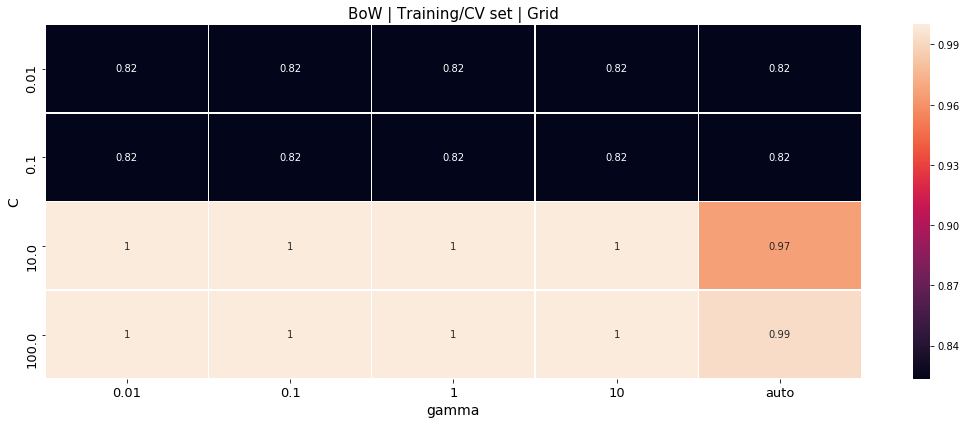

In [0]:
heatmap(c_gamma_score(clf_grid.cv_results_), vector_type='BoW', search_type='Grid')

Import prettytable to summarize the results in a table

In [0]:
# !pip install PrettyTable
# from prettytable import PrettyTable
from prettytable import PrettyTable
table = PrettyTable()

Calculate the ratios.

In [0]:
cm_bow_train, cm_bow_test = give_me_ratios(X_train_transformed_bow_std, y_train, X_test_transformed_bow_std, y_test, 'Bag of Words','Grid Search', table, clf_grid, clf_grid.best_params_['C'],clf_grid.best_params_['gamma'])

+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
| Vector Type  | Parameter Search | Data Set | Best C | Best Gamma | Precision | Recall | TNR  | FPR  | FNR  | Accuracy |
+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
| Bag of Words |   Grid Search    |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
| Bag of Words |   Grid Search    |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+


Plot the confusion matrix.

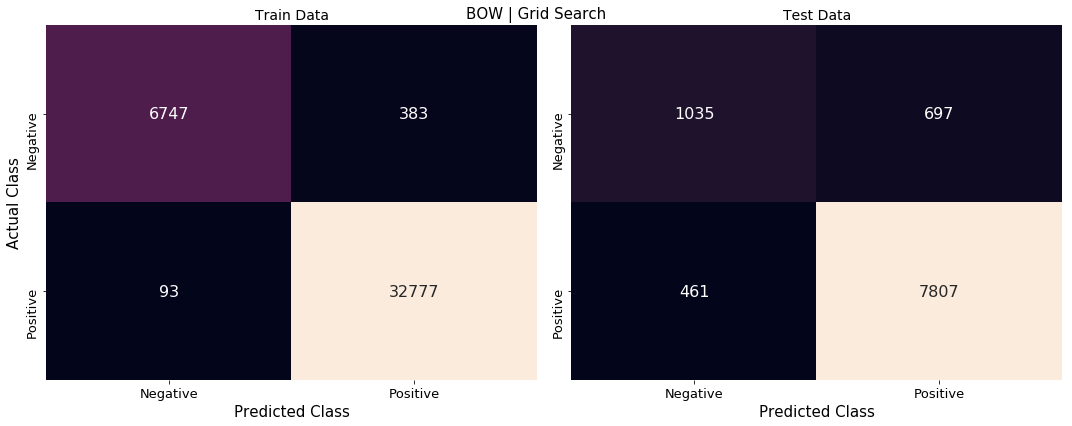

In [0]:
plot_confusion_matrix(cm_bow_train, cm_bow_test, title="BOW | Grid Search")

**Random Search | BOW**

Same as before, but this time using RandomizedSearchCV()

In [0]:
clf_random = RandomSearch(X_train_transformed_bow_std)

In [0]:
%%notify
%%time

clf_random.fit(X_train_transformed_bow_std, y_train)

Display heatmap of accuracy score. Remember that -1 indicates values which were not tried.

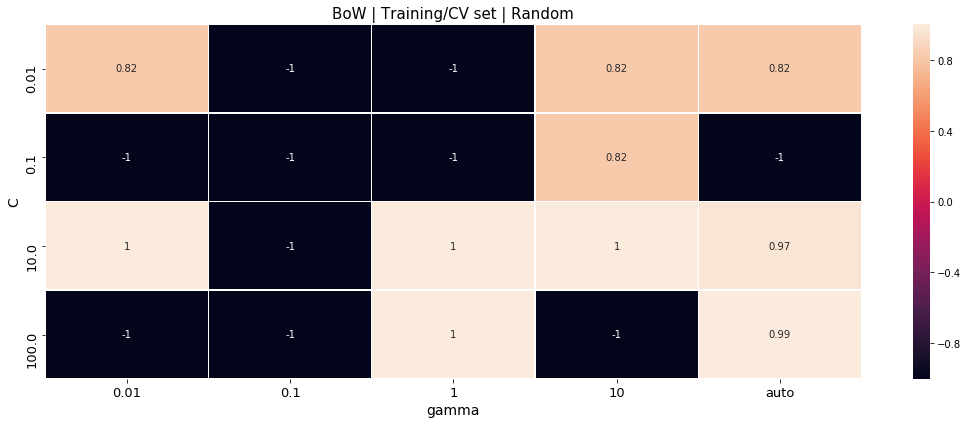

In [0]:
heatmap(c_gamma_score(clf_random.cv_results_), vector_type='BoW', search_type='Random')

Get ratios.

In [0]:
cm_bow_train, cm_bow_test = give_me_ratios(X_train_transformed_bow_std, y_train, X_test_transformed_bow_std, y_test, 'Bag of Words','Random Search', table, clf_random, clf_random.best_params_['C'],clf_random.best_params_['gamma'])

+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
| Vector Type  | Parameter Search | Data Set | Best C | Best Gamma | Precision | Recall | TNR  | FPR  | FNR  | Accuracy |
+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
| Bag of Words |   Grid Search    |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
| Bag of Words |   Grid Search    |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
| Bag of Words |  Random Search   |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
| Bag of Words |  Random Search   |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+


Plot confusion matrix

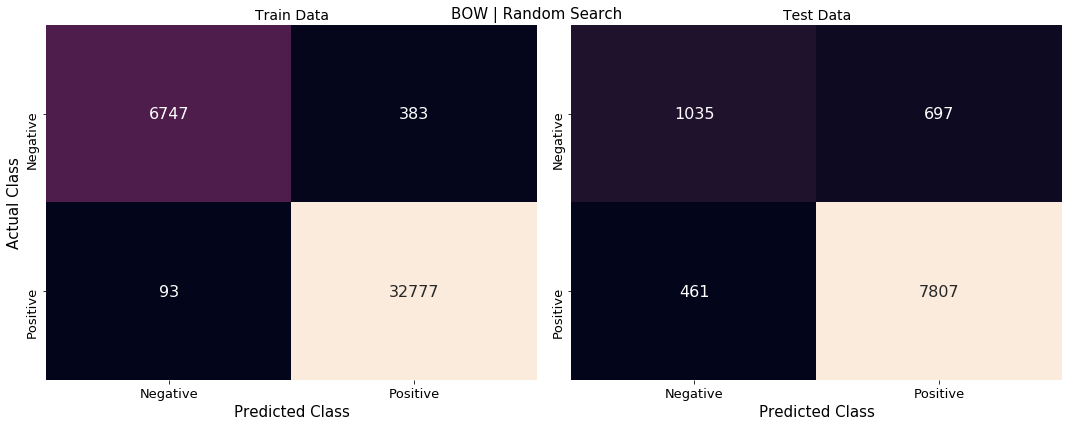

In [0]:
plot_confusion_matrix(cm_bow_train, cm_bow_test, "BOW | Random Search")

## Tfidf

In this section, we'll apply SVC on reviews represented in the Tfidf format. Load the transformed train and test sets.

In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_tfidf_full_nparray.pkl', 'rb')
X_train_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_tfidf is : {}'.format(type(X_train_transformed_tfidf)))
print('The shape of X_train_transformed_tfidf is : {}'.format(X_train_transformed_tfidf.shape))

The datatype of X_train_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_tfidf is : (291336, 64221)


In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_tfidf_full_nparray.pkl', 'rb')
X_test_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_tfidf is : {}'.format(type(X_test_transformed_tfidf)))
print('The shape of X_test_transformed_tfidf is : {}'.format(X_test_transformed_tfidf.shape))

The datatype of X_test_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_test_transformed_tfidf is : (72835, 64221)


Like we did for Bow, select a subset of the data to work with.

In [0]:
# y_train = y_train[:500]
# y_test = y_test[:500]
X_train_transformed_tfidf = X_train_transformed_tfidf[-40000:]
X_test_transformed_tfidf = X_test_transformed_tfidf[:10000]

Standardize data

In [0]:
scaler = StandardScaler(with_mean = False)
X_train_transformed_tfidf_std = scaler.fit_transform(X_train_transformed_tfidf)

In [0]:
X_test_transformed_tfidf_std = scaler.transform(X_test_transformed_tfidf)

**GridSearch | TFIDF **

In [0]:
clf_grid = GridSearch(X_train_transformed_tfidf_std)

Train the model

In [0]:
%%notify
%%time

clf_grid.fit(X_train_transformed_tfidf_std, y_train)

Display accuracy heatmap

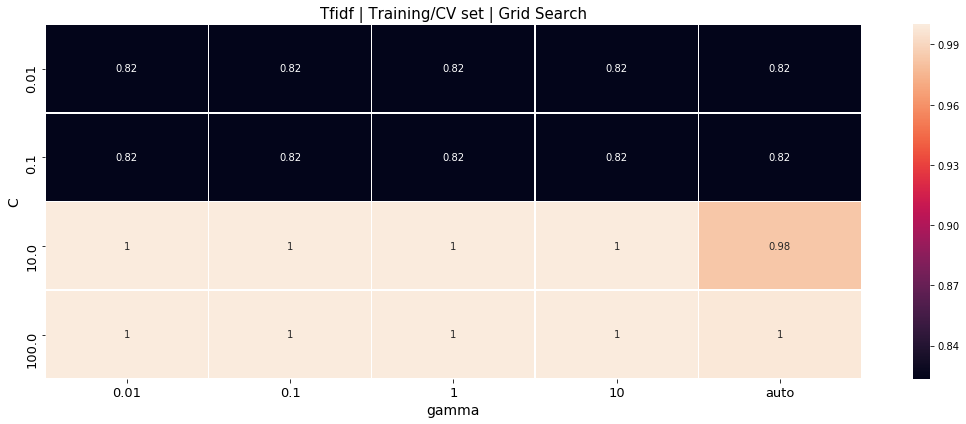

In [0]:
heatmap(c_gamma_score(clf_grid.cv_results_), vector_type='Tfidf', search_type='Grid Search')

Create ratios

In [0]:
%%notify

cm_tfidf_train, cm_tfidf_test = give_me_ratios(X_train_transformed_tfidf_std, y_train, X_test_transformed_tfidf_std, y_test, 'TFIDF','Grid Search', table, clf_grid, clf_grid.best_params_['C'],clf_grid.best_params_['gamma'])

+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
| Vector Type  | Parameter Search | Data Set | Best C | Best Gamma | Precision | Recall | TNR  | FPR  | FNR  | Accuracy |
+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
| Bag of Words |   Grid Search    |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
| Bag of Words |   Grid Search    |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
| Bag of Words |  Random Search   |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
| Bag of Words |  Random Search   |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
|    TFIDF     |   Grid Search    |  Train   |   10   |    auto    |    0.98   |  1.0   | 0.89 | 0.11 | 0.0  | 0.977175 |
|    TFIDF     |   Grid 

<IPython.core.display.Javascript object>

Plot the confusion matrix.

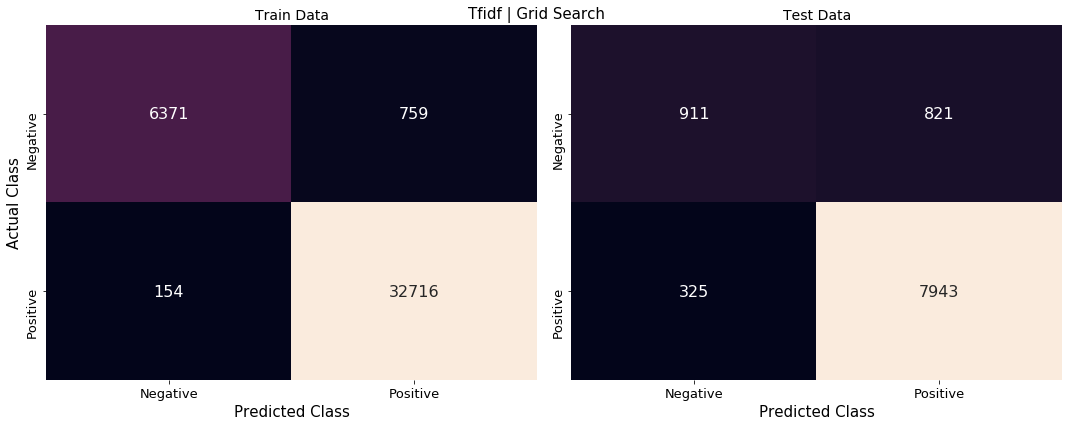

In [0]:
plot_confusion_matrix(cm_tfidf_train, cm_tfidf_test, "Tfidf | Grid Search")

**Random Search | TFIDF **

In [0]:
clf_random = RandomSearch(X_train_transformed_tfidf_std)

In [0]:
%%notify
%%time

clf_random.fit(X_train_transformed_tfidf_std, y_train)

CPU times: user 20min 25s, sys: 360 ms, total: 20min 25s
Wall time: 1h 30min 6s


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f644cfbfdb0>,
          error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=16,
          param_distributions={'C': [0.01, 0.1, 10, 100], 'gamma': ['auto', 0.01, 0.1, 1, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

<IPython.core.display.Javascript object>

Display heatmap

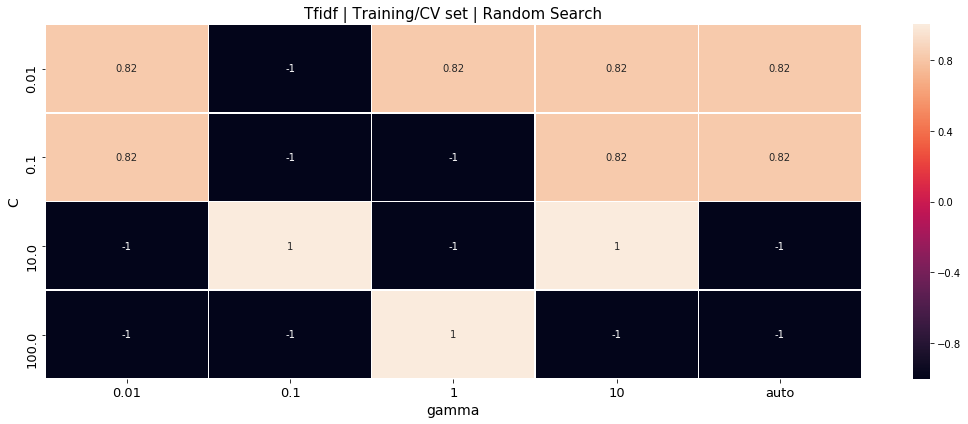

In [0]:
heatmap(c_gamma_score(clf_random.cv_results_), vector_type='Tfidf', search_type='Random Search')

Get ratios

In [0]:
cm_tfidf_train, cm_tfidf_test = give_me_ratios(X_train_transformed_tfidf_std, y_train, X_test_transformed_tfidf_std, y_test, 'TFIDF','Random Search', table, clf_random, clf_random.best_params_['C'],clf_random.best_params_['gamma'])

+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
| Vector Type  | Parameter Search | Data Set | Best C | Best Gamma | Precision | Recall | TNR  | FPR  | FNR  | Accuracy |
+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
| Bag of Words |   Grid Search    |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
| Bag of Words |   Grid Search    |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
| Bag of Words |  Random Search   |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
| Bag of Words |  Random Search   |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
|    TFIDF     |   Grid Search    |  Train   |   10   |    auto    |    0.98   |  1.0   | 0.89 | 0.11 | 0.0  | 0.977175 |
|    TFIDF     |   Grid 

Confusion matrix

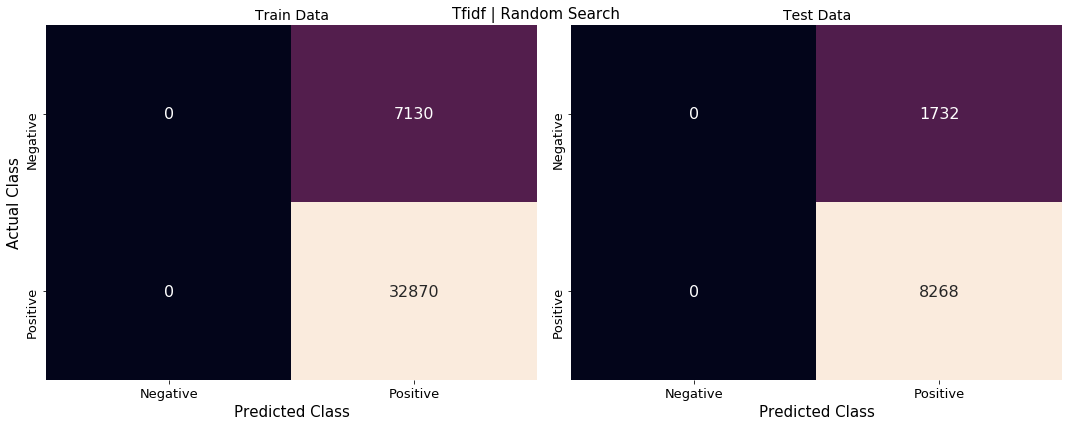

In [0]:
plot_confusion_matrix(cm_tfidf_train, cm_tfidf_test, "Tfidf | Random Search")

## Avg W2V

In this section, we'll apply SVC on data represented in the avg. W2V format.
load the train and test data stored on disk.

In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_avgW2V is : {}'.format(type(X_train_transformed_avgW2V)))
print('The shape of X_train_transformed_avgW2V is : {}'.format(X_train_transformed_avgW2V.shape))

The datatype of X_train_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_avgW2V is : (291336, 50)


In [0]:
#f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_avgW2V is : {}'.format(type(X_test_transformed_avgW2V)))
print('The shape of X_test_transformed_avgW2V is : {}'.format(X_test_transformed_avgW2V.shape))

The datatype of X_test_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_test_transformed_avgW2V is : (72835, 50)


Select subset of data

In [0]:
X_train_transformed_avgW2V = X_train_transformed_avgW2V[-40000:]
X_test_transformed_avgW2V = X_test_transformed_avgW2V[:10000]

Standardize the data

In [0]:
scaler = StandardScaler(with_mean = True)
X_train_transformed_avgW2V_std = scaler.fit_transform(X_train_transformed_avgW2V)

In [0]:
X_test_transformed_avgW2V_std = scaler.transform(X_test_transformed_avgW2V)

**GridSearch | avg. W2V **



In [0]:
clf_grid = GridSearch(X_train_transformed_avgW2V_std)

In [0]:
%%notify
%%time

clf_grid.fit(X_train_transformed_avgW2V_std, y_train)

Display heatmap

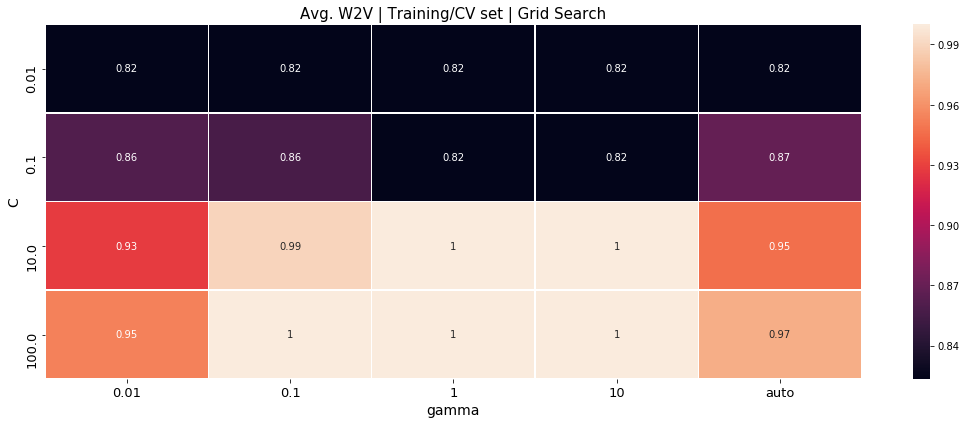

In [0]:
heatmap(c_gamma_score(clf_grid.cv_results_), vector_type='Avg. W2V', search_type='Grid Search')

Update the table with ratios of Avg. W2V.

In [0]:
%%notify

cm_w2v_train, cm_w2v_test = give_me_ratios(X_train_transformed_avgW2V_std, y_train, X_test_transformed_avgW2V_std, y_test, 'Avg. W2V','Grid Search', table, clf_grid, clf_grid.best_params_['C'],clf_grid.best_params_['gamma'])

+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
| Vector Type  | Parameter Search | Data Set | Best C | Best Gamma | Precision | Recall | TNR  | FPR  | FNR  | Accuracy |
+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
| Bag of Words |   Grid Search    |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
| Bag of Words |   Grid Search    |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
| Bag of Words |  Random Search   |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
| Bag of Words |  Random Search   |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
|    TFIDF     |   Grid Search    |  Train   |   10   |    auto    |    0.98   |  1.0   | 0.89 | 0.11 | 0.0  | 0.977175 |
|    TFIDF     |   Grid 

<IPython.core.display.Javascript object>

Plot the confusion matrix.

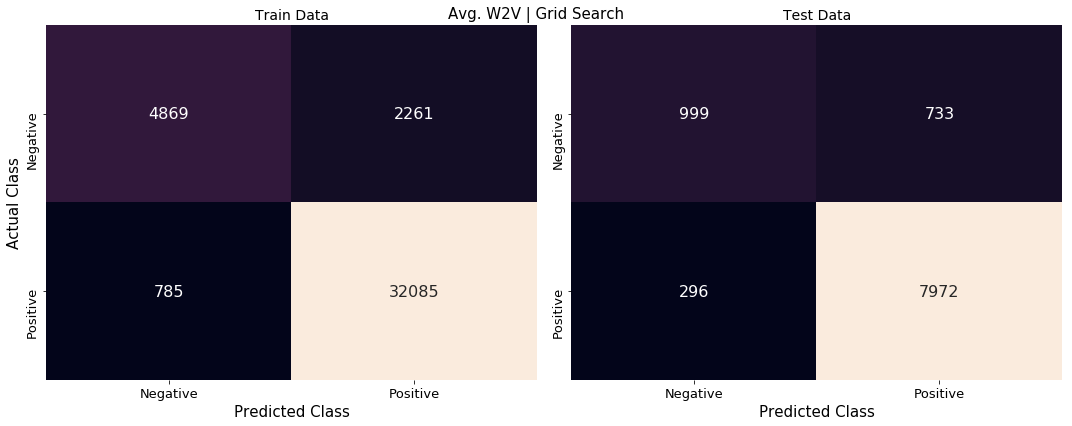

In [0]:
plot_confusion_matrix(cm_w2v_train, cm_w2v_test, "Avg. W2V | Grid Search")

**Random Search | avg. W2V **

In [0]:
clf_random = RandomSearch(X_train_transformed_avgW2V_std)

In [0]:
%%notify
%%time

clf_random.fit(X_train_transformed_avgW2V_std, y_train)

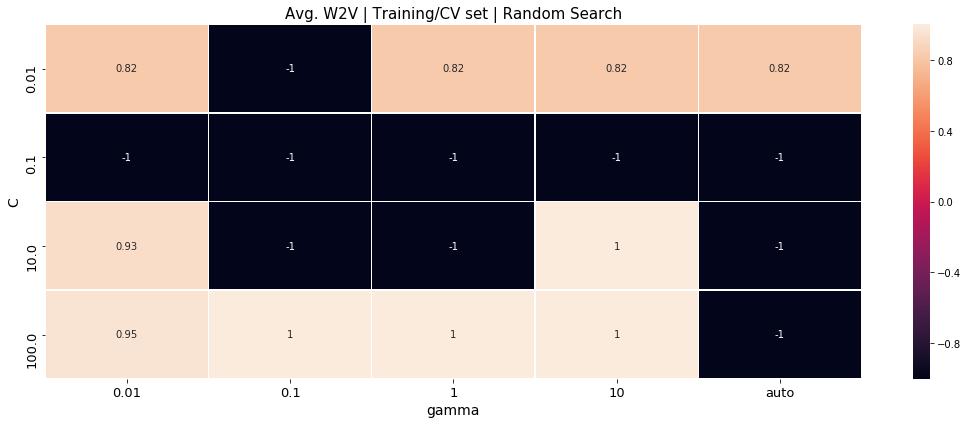

In [0]:
heatmap(c_gamma_score(clf_random.cv_results_), vector_type='Avg. W2V', search_type='Random Search')

Display ratios

In [0]:
%%notify

cm_w2v_train, cm_w2v_test = give_me_ratios(X_train_transformed_avgW2V_std, y_train, X_test_transformed_avgW2V_std, y_test, 'Avg. W2V','Random Search', table, clf_random, clf_random.best_params_['C'],clf_random.best_params_['gamma'])

+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
| Vector Type  | Parameter Search | Data Set | Best C | Best Gamma | Precision | Recall | TNR  | FPR  | FNR  | Accuracy |
+--------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
| Bag of Words |   Grid Search    |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
| Bag of Words |   Grid Search    |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
| Bag of Words |  Random Search   |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
| Bag of Words |  Random Search   |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
|    TFIDF     |   Grid Search    |  Train   |   10   |    auto    |    0.98   |  1.0   | 0.89 | 0.11 | 0.0  | 0.977175 |
|    TFIDF     |   Grid 

<IPython.core.display.Javascript object>

Confusion matrix

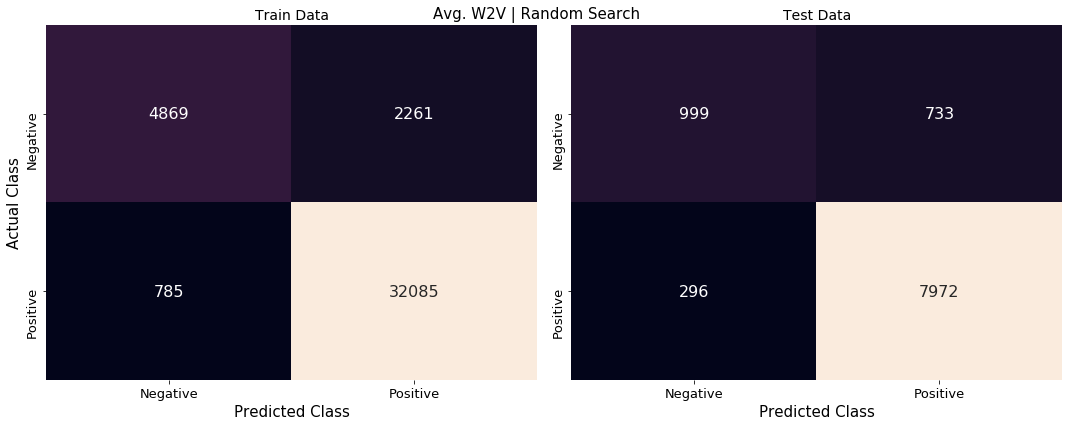

In [0]:
plot_confusion_matrix(cm_w2v_train, cm_w2v_test, "Avg. W2V | Random Search")

## Tfidf weighted W2V

In this last section, we apply SVC on vectors represented in the form of Tfidf weighted W2V.

In [0]:
#f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_TfidfW2V is : {}'.format(type(X_train_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_train_transformed_TfidfW2V.shape))

The datatype of X_train_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (291336, 50)


In [0]:
# f = open(r'D:\data_science\datasets\amazon2\X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_test_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_test_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_test_transformed_TfidfW2V is : {}'.format(type(X_test_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_test_transformed_TfidfW2V.shape))

The datatype of X_test_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (72835, 50)


In [0]:
X_train_transformed_TfidfW2V = X_train_transformed_TfidfW2V[-40000:]
X_test_transformed_TfidfW2V = X_test_transformed_TfidfW2V[:10000]

Standardize data

In [0]:
scaler = StandardScaler(with_mean = True)
X_train_transformed_TfidfW2V_std = scaler.fit_transform(X_train_transformed_TfidfW2V)

In [0]:
X_test_transformed_TfidfW2V_std = scaler.transform(X_test_transformed_TfidfW2V)

**GridSearch | Tfidf Weighted W2V**

In [0]:
clf_grid = GridSearch(X_train_transformed_TfidfW2V_std)

In [0]:
%%notify
%%time

clf_grid.fit(X_train_transformed_TfidfW2V_std, y_train)

Heatmap of score

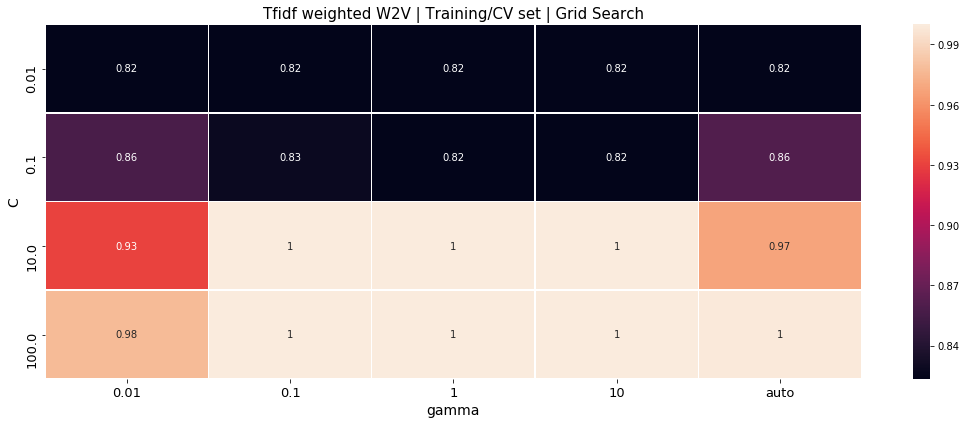

In [0]:
heatmap(c_gamma_score(clf_grid.cv_results_), vector_type='Tfidf weighted W2V', search_type='Grid Search')

In [0]:
cm_tfidfw2v_train, cm_tfidfw2v_test = give_me_ratios(X_train_transformed_TfidfW2V_std, y_train, X_test_transformed_TfidfW2V_std, y_test, 'Tfidf weighted W2V','Grid Search', table, clf_grid, clf_grid.best_params_['C'],clf_grid.best_params_['gamma'])

Confusion Matrix.

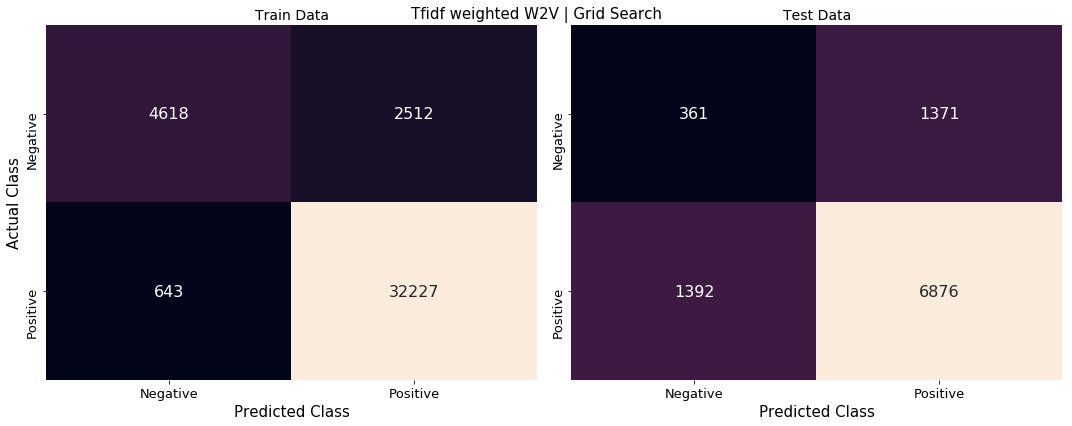

In [0]:
plot_confusion_matrix(cm_tfidfw2v_train, cm_tfidfw2v_test, "Tfidf weighted W2V | Grid Search")

**Random Search | Tfidf Weighted W2V**

In [0]:
clf_random = GridSearch(X_train_transformed_TfidfW2V_std)

In [0]:
%%notify
%%time

clf_random.fit(X_train_transformed_TfidfW2V_std, y_train)

Heatmap of scores

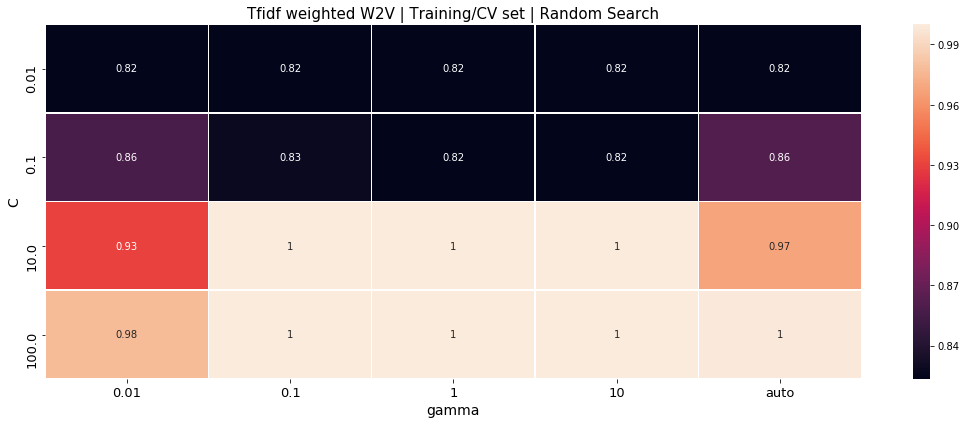

In [0]:
heatmap(c_gamma_score(clf_random.cv_results_), vector_type='Tfidf weighted W2V', search_type='Random Search')

Display scores final

In [0]:
cm_tfidfw2v_train, cm_tfidfw2v_test =  give_me_ratios(X_train_transformed_TfidfW2V_std, y_train, X_test_transformed_TfidfW2V_std, y_test, 'Tfidf weighted W2V','Random Search', table, clf_random, clf_random.best_params_['C'],clf_random.best_params_['gamma'])

+--------------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
|    Vector Type     | Parameter Search | Data Set | Best C | Best Gamma | Precision | Recall | TNR  | FPR  | FNR  | Accuracy |
+--------------------+------------------+----------+--------+------------+-----------+--------+------+------+------+----------+
|    Bag of Words    |   Grid Search    |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
|    Bag of Words    |   Grid Search    |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
|    Bag of Words    |  Random Search   |  Train   |  100   |    auto    |    0.99   |  1.0   | 0.95 | 0.05 | 0.0  |  0.9881  |
|    Bag of Words    |  Random Search   |   Test   |  100   |    auto    |    0.92   |  0.94  | 0.6  | 0.4  | 0.06 |  0.8842  |
|       TFIDF        |   Grid Search    |  Train   |   10   |    auto    |    0.98   |  1.0   | 0.89 | 0

Confusion Matrix

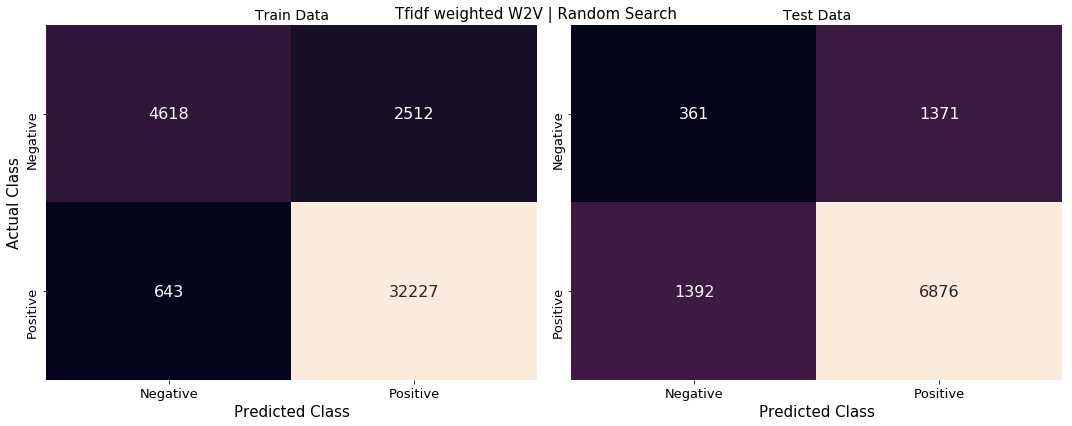

In [0]:
plot_confusion_matrix(cm_tfidfw2v_train, cm_tfidfw2v_test, "Tfidf weighted W2V | Random Search")

### Conclusion:

* We applied SVC on amazon food reviews for various vector representations.

* Found the best C and gamma using GridSearch and RandomizedSearch. 
* Plotted the confusion matrix for train and test data and also calculated several important ratios based on it such as Precision, Recall, FNR, etc.
